In [3]:
import torch
import torch.nn as nn
from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from pyhessian.utils import get_params_grad
from functorch import jvp, grad, vjp

epochs = 5
n_tasks = 3
L = 0
gamma0 = 10
widths = [32]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(123)
batch = 500

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param=='ntk':
                    self.gamma = gam
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.layers = nn.ModuleList(nn.Linear(self.w,self.w, bias=False) for _ in range(L))   
                self.fc2 = nn.Linear(self.w, 10, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                x = self.relu(self.fc1(x))/(784**0.5)
                for l in self.layers:
                    x = self.relu(l(x))/self.w**0.5
                x = self.fc2(x)/(self.w**0.5*self.gamma)

                return x
            
@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()

def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
data = pd.read_csv('~/data/MNIST/mnist_train.csv')
test = pd.read_csv('~/data/MNIST/mnist_test.csv')
#data = data[data['label'].isin([0, 1])]
#test = test[test['label'].isin([0, 1])]
X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.eye(10, device=device)[Y_temp]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.eye(10, device=device)[Y_temp]

tasks = [X]
tasks_test = [X_test]

for _ in range(n_tasks):
        perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=perm)).to(device))


def top_eigen(model, loss, X, Y, prt=False):

            hess_comp = hessian(model, loss, (X,Y) )
            top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
                
            return top_eigenvalues[-1] , top_eigenvector

def overlap(model, inputs, targets):
    
    gradients = torch.cat([param.grad.view(-1) for param in model.parameters()])
    params = torch.cat([param.data.view(-1) for param in model.parameters()])

    def loss_fn(params):
        idx = 0
        layers = []
        for param in model.parameters():
            param_numel = param.numel()
            layers.append(params[idx:idx + param_numel].view_as(param))
            idx += param_numel
        relu = nn.ReLU()
        outputs = relu(inputs@layers[0].T) @ layers[1].T
        return MSE(outputs, targets)

    hvp = torch.autograd.functional.hvp(loss_fn, params, gradients)[1]
    return (torch.dot(hvp,gradients)/(torch.norm(hvp) * torch.norm(gradients))).item()


In [4]:
for regime in ['ntk','mup']:
    for N in widths:
        eos = 2/N

        loss_hist = []
        lam = []
        acc = []
        all = []
        
        mlp = MLP(N,L,regime, gamma0)
        mlp = mlp.apply(init_weights)
        summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr=2/eos*gamma0)
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):

                        running_loss = 0.0
                        for i in range(len(Xt)//batch):

                            # Batch of training 
                            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

                            ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

                            lt = []
                            for s in range(t+1):
                                sharp, eigen = top_eigen(mlp, MSE, tasks[s][ixc], Y[ixc])
                                lt.append(sharp)
                            lam.append(lt)    

                            optimizer.zero_grad()

                            out = mlp(Xt[ix])
                            loss = MSE(out, Y[ix])
                            loss.backward()
                            running_loss += loss.item()

                            all.append(overlap(mlp, X[ix], Y[ix]))

                            optimizer.step()
                            loss_hist.append(loss.item())
                            #print(f'task {t} : (epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f}')

                print(f'Finished Training task{t}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.argmax(mlp(tasks_test[s]), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item() )  
                acc.append(acct) 

        with open(f'data/lamda{N}_{regime}.txt', 'w') as file:
        
            for lst in lam:
                file.write(' '.join(map(str, lst)) + ' ')

        with open(f'data/acc{N}_{regime}.txt', 'w') as file:

            for lst in acc:
                file.write(' '.join(map(str, lst)) + ' ')

        with open(f'data/overlap{N}_{regime}.txt', 'w') as file:

            for a in all:
                file.write(str(a) + ' ')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 32]          25,088
              ReLU-2                [-1, 1, 32]               0
            Linear-3                [-1, 1, 10]             320
Total params: 25,408
Trainable params: 25,408
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
Finished Training task0, train loss: 0.00898453287780285
Finished Training task1, train loss: 0.0069224189259111885
Finished Training task2, train loss: 0.006498551905155182
Finished Training task3, train loss: 0.007029927473515272
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   

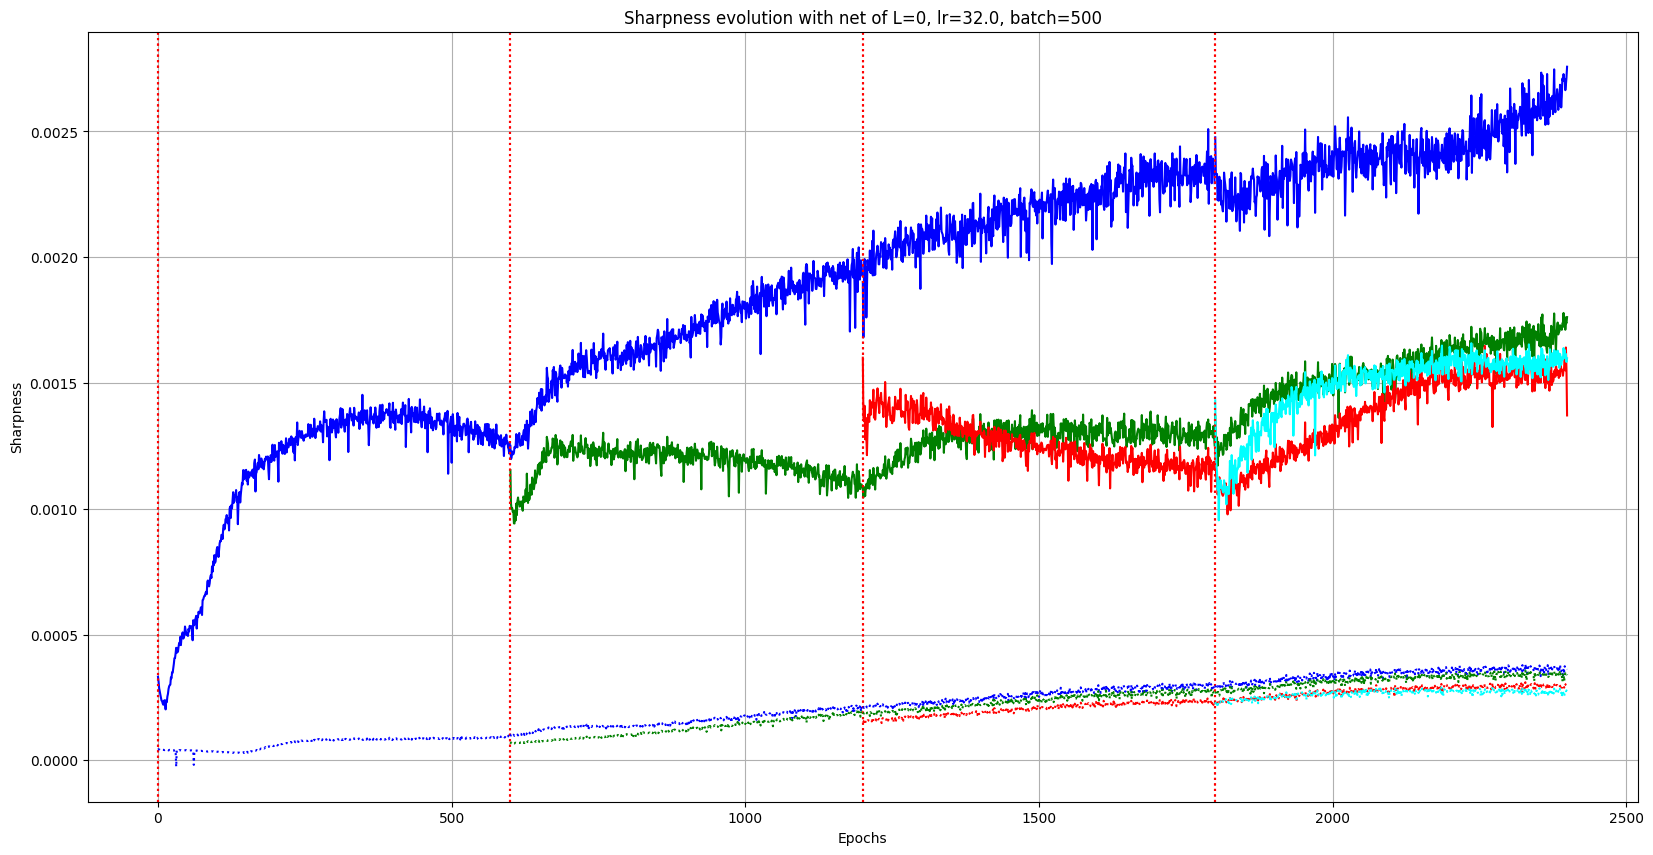

In [6]:
def SHARP():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    plt.figure(figsize=(20,10))
    plt.title(f'Sharpness evolution with net of L={L}, lr={2/eos}, batch={batch}')
    N = 32
    for regime,ls in zip(['ntk','mup'],['-',':']):

        lam_reconstructed = []

        with open(f'data/lamda{N}_{regime}.txt', 'r') as file:
            lines = file.readlines()

        for line in lines:
            lst = list(map(float, line.strip(',').split()))
            lam_reconstructed.append(lst)
                
        a = np.array(lam_reconstructed).T

        sh1 = a[0:T]
        sh2 = a[T:3*T]
        sh3 = a[3*T:6*T]
        sh4 = a[6*T:10*T]
    
        for i,sh in enumerate([sh1,sh2,sh3,sh4]):
            plt.axvline(i*T, color='r', linestyle='dotted')
            for j,row in enumerate(sh.reshape(T,i+1).T):
                plt.plot(np.arange(i*T,(i+1)*T,1), row, color=colors[j], linestyle=ls)

    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    #plt.axhline(eos, color='black', linestyle='dotted')
    plt.grid()
    plt.show()

SHARP()

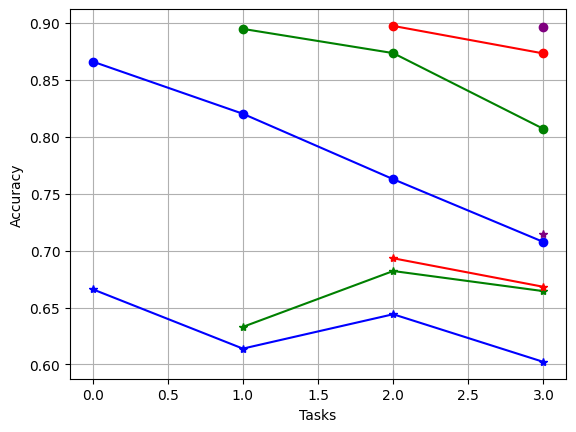

In [8]:
def ACC():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    N = 32
    for regime,ls in zip(['ntk','mup'],['o','*']):

        acc_reconstructed = []

        with open(f'data/acc{N}_{regime}.txt', 'r') as file:
            lines = file.readlines()

        for line in lines:
            lst = list(map(float, line.strip(',').split()))
            acc_reconstructed.append(lst)
                
        a = np.array(acc_reconstructed).T

        accs = [a[:1],a[1:3],a[3:6],a[6:10]]

        for i in range(n_tasks):
                plt.plot(range(i,n_tasks+1),[a[i] for a in accs[i:]], color=colors[i], marker=ls)
        plt.plot(n_tasks,accs[-1][-1], color=colors[-1], marker=ls )
        
    plt.ylabel('Accuracy')
    plt.xlabel('Tasks')
    plt.grid()
    plt.show()
ACC()

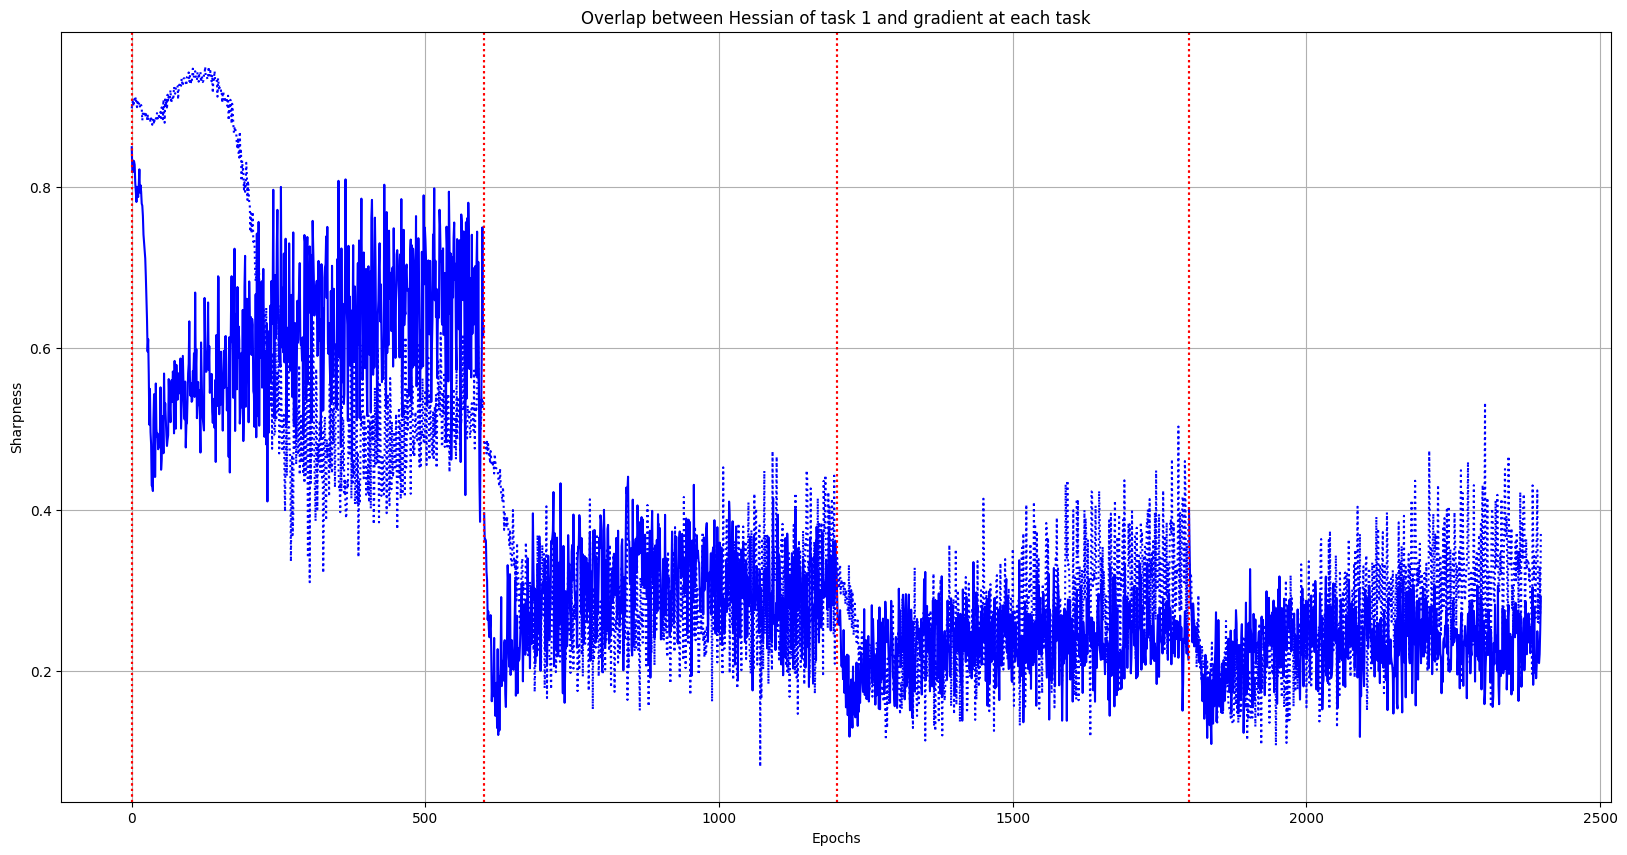

In [9]:
def OVERLAP():
    T = epochs*len(X)//batch
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']
    
    plt.figure(figsize=(20,10))
    plt.title(f'Overlap between Hessian of task 1 and gradient at each task')
    N = 32
    for regime,ls in zip(['ntk','mup'],['-',':']):

        lam_reconstructed = []

        with open(f'data/overlap{N}_{regime}.txt', 'r') as file:
            lines = file.readlines()

        for line in lines:
            lst = list(map(float, line.strip(',').split()))
            lam_reconstructed.append(lst)
                
        a = np.array(lam_reconstructed).T

        sh1 = a[0:T]
        sh2 = a[T:2*T]
        sh3 = a[2*T:3*T]
        sh4 = a[3*T:4*T]

        for i,sh in enumerate([sh1,sh2,sh3,sh4]):
            plt.axvline(i*T, color='r', linestyle='dotted')
            for j,row in enumerate(sh.T):
                plt.plot(np.arange(i*T,(i+1)*T,1), row, color=colors[j], linestyle=ls)

    plt.ylabel('Sharpness')
    plt.xlabel('Epochs')
    plt.grid()
    plt.show()

OVERLAP()

In [ ]:
HTL

In [ ]:
N = 64
sharp0 = np.array(lam[0:epochs*len(Xt)//batch]).T
sharp1 = np.array(lam[epochs*len(Xt)//batch:2*epochs*len(Xt)//batch]).T
sharp2 = np.array(lam[2*epochs*len(Xt)//batch:3*epochs*len(Xt)//batch]).T
sharp3 = np.array(lam[3*epochs*len(Xt)//batch:4*epochs*len(Xt)//batch]).T

sharps = [sharp0,sharp1,sharp2, sharp3]

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'orange', 'purple']

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title(f'Sharpness evolution with net of w={N}, L={L}, lr={2/eos}, batch={batch}')

for i,s in enumerate(sharps):
    ax.axvline(i*epochs*len(Xt)//batch, color='r', linestyle='dotted')
    for j,row in enumerate(s):
        ax.plot(np.arange(i*epochs*len(Xt)//batch,(i+1)*epochs*len(Xt)//batch,1), row, color=colors[j] )
ax.set_ylabel('Sharpness')
ax.set_xlabel('Epochs')
#plt.axhline(eos, color='black', linestyle='dotted')
plt.show()


In [ ]:
acc0 = np.array(acc[0])
acc1 = np.array(acc[1])
acc2 = np.array(acc[2])
acc3 = np.array(acc[3])

#acc4 = np.array(acc[4])
#acc5 = np.array(acc[5])
#acc6 = np.array(acc[6])
#acc7 = np.array(acc[7])
#acc8 = np.array(acc[8])
#acc9 = np.array(acc[9]
accs = [acc0,acc1,acc2, acc3]

        #,acc4,acc5,acc6,acc7,acc8,acc9
plt.figure(figsize=(20,10))
plt.title(f'Accuracy evolution with net of w={N}, L={L}, lr={2/eos}, batch={batch}')
for i in range(n_tasks):
        plt.plot(range(i,n_tasks+3),[a[i] for a in accs[i:]], color=colors[i], marker='o' )
plt.plot(n_tasks,accs[-1][-1], color=colors[-1], marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Tasks')
plt.show()

In [ ]:
a = np.array(lam)

In [ ]:
plt.plot(a)
accs